# Prodigy game algorithmic design challenge
## Background
You are given a list of tasks $T = T_1, T_2, \dots,T_n$. 
Each task is to be done on a computer. 
Some tasks are easy, other tasks are hard. 
(Some examples of tasks could be typing, or coding, or answering multiple-choice questions.) 
You also have a set of users $U$ who have different abilities on these tasks.

The goal of this challenge is to produce a pseudo-code heuristic to solve each step of the challenge, supported by explanations, assumptions, or working code.
## Import dependencies

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from bots import same_dif_bot

## Question difficulty
You want to estimate the difficulty of each task. Each user is given a random sample of tasks from T to attempt. How can you use the performance of users (on the random task sample they are given) to estimate the difficulty of all the tasks in T?  (You can only use observations on the computational tasks - no biometrics, direct observation, etc. Imagine you can see what is on a user’s computer screen but nothing else.)
### Absolute difficulty measures
#### Basic case: all students are equal, all tasks are equal

Mean of student scores: 0.50
Std of student scores: 0.02


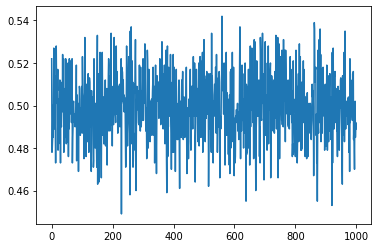

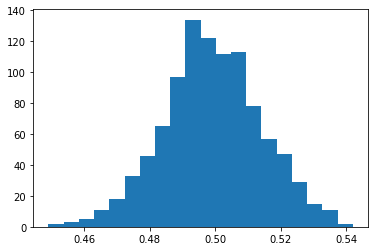

In [23]:
num_users = 1000
num_tasks = 1000
user_scores = []
for _ in range(num_users):
    scores = [random.randint(0, 1) for _ in range(1, num_tasks)]
    user_scores.append(sum(scores) / num_tasks)
print("Mean of student scores: {0:.2f}\nStd of student scores: {1:.2f}"
      .format(np.mean(user_scores),
              np.std(user_scores)))
plt.plot(user_scores)
plt.show()
plt.hist(user_scores, bins=20)
plt.show()

#### Difficulty index
When discussing task difficulty, there are two distinct definitions that have to be considered:

1. Absolute measure of task difficulty, as expressed by the ratio of all correct answers to total attempted answers for a given question.
This measure indicates the difficulty of a given question with respect to the complete student population for a given school year.

2. Relative measure of task difficulty, defined as absolute task difficulty corrected for current level of abilities of a given user.

Questions can be classified by difficulty in two steps:

1. questions can be grouped by school year

2. difficulty can be determined as the fraction of correct responses to the question from users of the corresponding age group

Difficulty of a question is determined by the number of correct answers vs total answers provided:

$p(Q) = \large{ \frac{\text{Correct answers}} {\text{Total answers}} }$

Rough "rule-of-thumb" classification of questions by difficulty $p$ according to the difficulty index:

|  Difficulty |         p        |
|-------------|------------------|
|  Very easy  |      p > 0.8     |
|     Easy    |  0.6 < p <= 0.8  |
|   Moderate  |  0.4 < p <= 0.6  |
|     Hard    |  0.2 < p <= 0.4  |
|  Very hard  |      p < 0.2     |

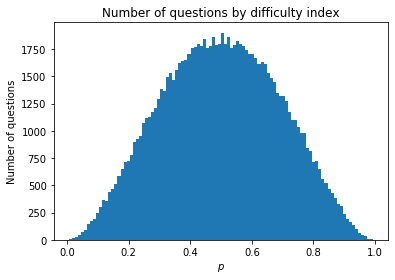

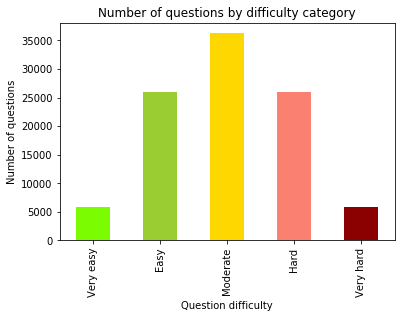

In [2]:
def question_categorizer(question_p):
    """
    categorizes a question based on its difficulty index
    :param question_p: float
        difficulty = correct answers / total answers
    :return: string
        category of the question difficulty
    """
    if question_p > 0.8:
        return 'Very easy'
    elif question_p > 0.6:
        return 'Easy'
    elif question_p > 0.4:
        return 'Moderate'
    elif question_p > 0.2:
        return 'Hard'
    elif question_p > 0.0:
        return 'Very hard'
    else:
        return 'Error'

# generate a random sample of questions using beta distribution
questions = pd.DataFrame(np.random.beta(3, 3, size=100000), columns=['p'])

# categorize questions by difficulty
questions['difficulty'] = questions['p'].apply(question_categorizer)

questions['p'].hist(bins=100)
plt.title("Number of questions by difficulty index")
plt.ylabel("Number of questions")
plt.xlabel("$p$")
plt.grid(False)
plt.show()

col_order = ['Very easy', 'Easy', 'Moderate', 'Hard', 'Very hard']
questions['difficulty'].value_counts()[col_order].plot(kind='bar',
                                                       color=['lawngreen', 'yellowgreen', 
                                                              'gold', 'salmon', 'darkred'])
plt.title("Number of questions by difficulty category")
plt.ylabel("Number of questions")
plt.xlabel("Question difficulty")
plt.grid(False)
plt.show()

### Relative difficulty
#### User ranking
Users can be ranked by each school year by experience expressed as the number of correct answers, adjusted for question difficulty via coefficients:


|  Question difficulty |         p        | Ex coefficient  |
|----------------------|------------------|-----------------|
|      Very easy       |      p > 0.8     |        0.1      |
|         Easy         |  0.6 < p <= 0.8  |        0.5      |
|       Moderate       |  0.4 < p <= 0.6  |        1.0      |
|         Hard         |  0.2 < p <= 0.4  |        1.5      |
|      Very hard       |      p < 0.2     |        2.0      |

$ 
Ex(U) = 0.1 \cdot \text{count(very easy)} + 
0.5 \cdot \text{count(easy)} + 
1.0 \cdot \text{count(moderate)} + 
1.5 \cdot \text{count(hard)} + 
2.0 \cdot \text{count(very hard)} 
$

After calculating the experience of each user, all users can be ranked by experience and split into 5 quantiles.

#### Relative question difficulty based on user rank
For the purposes of selecting questions to be shown to the user, the question-feeding bot would consider selecting a question from one of the 3 question pools: easy, average, or challenging.
Questions for each of the 3 pools are selected based on the category of the absolute question difficulty determined using difficulty index and category of the user determined using the quintilies produced by ranking all users by experience.
The matching of absolute question difficulty to user ranking can be performed using the following table:

|  Rank (user / question) |QU1 (bottom 20%) | QU2 (20% to 40%) | QU3 (40% to 60%)  | QU4 (60% to 80%)  | QU5 (top 20%)  |
|-------------------------|-------------|-------------|-------------|-------------|----------|
|         Very easy       |   Average   |    Easy     |   Too easy  |  Too easy   | Too easy |
|            Easy         | Challenging |   Average   |     Easy    |  Too easy   | Too easy |
|          Moderate       |  Too hard   | Challenging |   Average   |     Easy    | Too easy |
|            Hard         |  Too hard   |   Too hard  | Challenging |   Average   |   Easy   |
|         Very hard       |  Too hard   |   Too hard  |  Too hard   | Challenging |  Average |

In [20]:
t = time()
users = pd.DataFrame(np.random.choice(['QU1', 'QU2', 'QU3', 'QU4', 'QU5'], size=10000), 
                     columns=['quintile'])

# probabilities of answering a question of a given difficulty for each user group
answer_matrix = {
    'QU1': {'Very easy': 0.5, 'Easy': 0.25, 'Moderate': 0.1, 'Hard': 0.05, 'Very hard': 0.01},
    'QU2': {'Very easy': 0.75, 'Easy': 0.5, 'Moderate': 0.25, 'Hard': 0.1, 'Very hard': 0.05},
    'QU3': {'Very easy': 0.9, 'Easy': 0.75, 'Moderate': 0.5, 'Hard': 0.25, 'Very hard': 0.1},
    'QU4': {'Very easy': 0.95, 'Easy': 0.9, 'Moderate': 0.75, 'Hard': 0.5, 'Very hard': 0.25},
    'QU5': {'Very easy': 0.99, 'Easy': 0.95, 'Moderate': 0.9, 'Hard': 0.75, 'Very hard': 0.5},
}

for idx, user in users.iterrows():
    # take a random sample of questions without replacement
    question_sample = np.random.choice(questions['difficulty'], replace=False, size=100)
    # initialize a dictionary to store correct and total answers
    corr_answers = {
        'Very easy': 0, 'Easy': 0, 'Moderate': 0, 'Hard': 0, 'Very hard': 0,
        'Very easy total': 0, 'Easy total': 0, 'Moderate total': 0, 'Hard total': 0, 'Very hard total': 0
    }
    for question in question_sample:
        # simulate answering questions
        corr_answers[question] += int(random.random() < answer_matrix[user['quintile']][question])
        corr_answers[question + ' total'] += 1
    
    for key, value in corr_answers.items():
        # record the number of correct and total answers
        users.loc[idx, key] = value

elapsed = time() - t
print("Finished, took {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60))

corr_cols = ['Very easy', 'Easy', 'Moderate', 'Hard', 'Very hard']
total_cols = ['Very easy total', 'Easy total', 'Moderate total', 'Hard total', 'Very hard total']
for i in range(len(corr_cols)):
    users[corr_cols[i] + ' perc'] = users[corr_cols[i]] / users[total_cols[i]]
perc_cols = ['Very easy perc', 'Easy perc', 'Moderate perc', 'Hard perc', 'Very hard perc']
users.groupby('quintile')[perc_cols].mean()

Finished, took 70.91 seconds (1.18 minutes)


,Very easy perc,Easy perc,Moderate perc,Hard perc,Very hard perc
quintile,,,,,
QU1,0.493312,0.250973,0.099654,0.051025,0.010230
QU2,0.742785,0.496083,0.246890,0.098665,0.051088
QU3,0.900592,0.751397,0.497386,0.251112,0.093335
QU4,0.947651,0.900081,0.752479,0.498487,0.249495
QU5,0.990733,0.949113,0.899760,0.747597,0.494169


In [28]:
corr_total = users[corr_cols].sum()
tot_total = users[total_cols].sum()
tot_total.index = corr_total.index
corr_total / tot_total

Very easy    0.815204
Easy         0.670118
Moderate     0.499133
Hard         0.330289
Very hard    0.180111
dtype: float64

## Question-feeding bot
## Formulating question difficulty selection as a Markov decision process
### Markov decision process (MDP)
A reinforcement learning (RL) problem, such as a question-feeding bot, can be formulated as a Markov decision process (MDP).
A Markov decision process is a discrete time stochastic control process. 
It provides a mathematical framework for modeling decision making in situations where outcomes are partly uncertain, and partly under the control of a decision maker.
MDP framework provides a formalization of the key elements of RL, such as value functions and expected reward.

An MDP expresses the problem of sequential decision making, where actions influence next states and the results.
In our case, question-feeding bot iteratively selects the difficulty level of each question to be shown to the user;
selected difficulty influences learning outcome (main reward) and the probability of user answering correctly, which in turn also influences learning outcome as well as the frustration level experienced by user (user exit condition).
### Key elements of MDP
An MDP is four-tuple ($S, A, P, R$):
* $S$ is the state space, with a finite set of states
    * bot's state is defined by the number of questions answered, cumulative reward and current user frustration level
* $A$ is the action space, with a finite set of actions
    * on each iteration, the bot has three possible actions to choose from: pick easy, average, or challenging question
* $P$ is a transition function, which defines the probability of reaching a state $s'$ from $s$ after performing an action $a$. 
The transition function is equal to the conditional probability of $s'$ given $s$ and $a$:
$ P(s', s, a) = p(s'|s, a) $
    * in the case of the bot, transition functions are determined by the probability of a user answering given difficulty of the question
* $R$ is the reward function, which determines the value received for transitioning from state $s$ to state $s'$ after performing the action $a$
    * bot's rewards are determined by the difficulty of the questions selected and by user's ability to answer them correctly

### Markov property
By definition, the transition function and the reward function posses the Markov property: their values are determined only by the current state, and not from the sequence of the previous states visited.
Markov property means that the process is memory-less and the future state depends only on the current one, and not on its history.
This way the current state holds all the information. A system with such a property is called **fully observable**.

In the current formulation of the question-feeding bot, probability of the user to answer the questions correctly is assumed to be determined solely by the question difficulty.
Similarly, reward is determined only by the difficulty of the question and whether the question was answered correctly.
Thus, question-feeding bot operates in a fully observalbe environment, where the current state holds all the information.
### Policy $\pi$
The final objective of an MDP is to find a policy, $\pi$, that maximizes the cumulative reward, $ \sum \limits_{t=0}^\infty R_\pi (s_t, s_{t+1} ) $,
where $R_\pi$ is the reward obtained at each step by following the policy, $\pi$.
A solution of an MDP is found when a policy takes the best possible action in each state of the MDP.
This policy is known as the **optimal policy**.
The policy chooses actions to be taken in a given situation and can be categorized as deterministic or stochastic.
Stochastic policies can be used to include noisy actions into the system.

### Return
When running a policy in an MDP, the sequence of state and action ( $ S_0, A_0, S_1, A_1, \dots $ ) is called **trajectory** or **rollout**, and is denoted by $\tau$. In each of bot's trajectories, a finite sequence of rewards will be collected as a result of bot's actions. A function of these rewards is called return and in its most simplified version, it is defined as follows:

$ G(\tau) = r_0 + r_1 + \dots + r_n = \sum \limits_{t=0}^n r_t $

It is considered common practice to use discount factors $G(\tau) = \sum \limits_{t=0}^\infty \lambda^t r_t $ for both infinite- and finite-horizon (**episodic**) tasks to show preference for actions that are closer in time with respect to those that will be encountered in the distant future.
However, in the case of the current formulation of the question-feeding bot, all the rewards are considered to be equally important and bot's tasks are assumed to have a finite and short horizon;
thus, simple return formulation with no discount factors has been used.

A trivial but useful decomposition of return is defining it recursively in terms of return at time step $t+1$:

$ G_t = r_t + G_{t+1} $

The goal of RL is to find an optimal policy, $\pi$, that maximizes the expected return as $argmax_\pi E_\pi[G(\tau)]$, where $E_\pi [\cdot]$ is the expected value of a random variable.

### Value function
The return $G(\tau)$ provides a good insight into the trajectory's value, but doesn't give any indication of the quality of the single states visited.
This quality indicator is important because it can be used by the policy to choose the next best action. 
The policy has to just choose the action that will result in the next state with the highest quality. The value function does exactly this: it estimates the quality in terms of the expected return from a state following a policy. Formally, the value function is defined as follows:

$V_\pi(s) = E_\pi[G|s_0=s] = E_\pi[ \sum \limits_{t=0}^k r_t |s_0 =s]$

The action-value function, similar to the value function, is the expected return from a state but is also conditioned on the first action. It is defined as follows:

$ Q_\pi(s, a) = E_\pi[G|s_0=s, a_0=a] = E_\pi [ \sum \limits_{t=0}^k r_t | s_0=s, a_0=a ] $

The value function and action-value function are also called the **V-function** and **Q-function** respectively, and are strictly correlated with each other since the value function can also be defined in terms of the action-value function:

$ V_\pi(s) = E_\pi[Q_\pi(s, a)] $

Knowing the optimal $Q^*$, the optimal value function is as follows:

$ V^*(s) = max_a Q^* (s, a) $

because the optimal action is $ a^* (s) = argmax_a Q^* (s, a) $.

### Bellman equation
$V$ and $Q$ can be estimated by running trajectories that follow the policy, $\pi$, and then averaging the values obtained. This technique is effective and is used in many contexts, but can be very expensive considering that the return requires the rewards from the full trajectory.

The Bellman equation defines the action-value function and the value function recursively, enabling their estimations from subsequent states. The Bellman equation does that by using the reward obtained in the present state and the value of its successor state. Using the recursive formulation of the return defined above:

$ V_\pi = E_\pi [G_t | s_0 = s] = E_\pi [r_t + G_{t+1} | s_0 = s] = E_\pi [r_t + V(s_{t+1}) | s_t = s, a_t \sim \pi(s_t) ] $

### Rewards and frustration
The question-feeding bot needs to select the sequence of questions to be shown to a player with the goal of presenting a maximum number of questions of highest complexity (estimated by current abilities of the player based on past history), while keeping player's frustration levels under the acceptable threshold.

In the game, **rewards experienced by players** are assumed to be driven mostly by in-game outcomes of successful actions (e.g., winning battles / extra damage for correct answers, coins and items for won battles, rising rank of the player, etc.). 

Similarly, main sources of **frustration** are assumed to be associated with the in-game outcomes of unsuccessful player actions (e.g., missed attack / lost battle due to a wrong answer, uncollected rewards, dropped player ranking, etc.).
In the context of the current formulation of the bot, frustration is taken into account as negative reward.
Thus, reduction of frustration via a correct answer accounted as a positive reward.
#TODO

Check citation about sources of frustration.
#### Learning outcomes
On the other hand, **learning outcome** of each playing session is determined by the difficulty and number of questions asked and by the level of effort put by the player while solving the presented question. 
Level of effort exhibited by a player is also assumed to be mostly driven by in-game consequences of wrong answers.

Learning outcomes are assumed to be maximized when players are faced with relatively hard questions (assessed by their current level of ability with a particular topic) and are putting an effort in attempting to answer them.
However, since incorrect answers to questions result in in-game penalties, they are assumed to raise the level of frustration of the player.
Thus, a well-balanced question feeding bot would be able to challenge the player with questions of maximum difficulty (assessed by their current level), while keeping their frustration levels low, and thus ensuring that the playing session is extended and more questions are presented.

#### Reward structure
Based on the conditions outlined above, the following reward structure can be used for the question-feeding bot:
At any time step $t$, after the player answers a question, the reward received by the bot will be driven by the relative difficulty of the quesiton and whether it was answered right or not.

|Question $Q_t$ | Answer $Ans_t$ | Learning $L_t$ | Frustration $F_t$ | Reward $R_t$ |
|---------------|----------------|----------------|-------------------|--------------|
|     Easy      |      Corr      |      + 0.5     |       + 0.5       |    + 1.0     |
|     Easy      |     Incorr     |        0.0     |       - 0.5       |    - 0.5     |
|    Average    |      Corr      |      + 1.5     |       + 0.5       |    + 2.0     |
|    Average    |     Incorr     |      + 0.5     |       - 0.5       |      0.0     |
|  Challenging  |      Corr      |      + 2.5     |       + 0.5       |    + 3.0     |
|  Challenging  |     Incorr     |      + 1.0     |       - 0.5       |    + 0.5     |

#### Reward function
At a time step $S_t$, the bot performs an action $A_t$ by selecting a question of difficulty level $Q_t$. Then, the reward $R_t$ is a sum of a learning outcome (as determined by question difficulty $Q_t$ and correctness of the received response $Ans_t$) and frustration factor $F_t$:

$R_t(Q_t, Ans_t) = L_t + F_t$

$\text{where } L_t = \begin{cases} 0.5 & if 2 \\ 3 & if 4 \end{cases}$

Probability that a user provides the correct answer for a question of a given difficulty Q_t (ignoring user rank):

$ P(Ans_t = Corr | Q_t) = p$, 

where $p$ is the question difficulty as determined by the difficulty index.

Probability $ P(Ans_t = Corr | U_i, Q_t) $ that a user of a given rank quintile $U_i$ provides the correct answer for a question of a given difficulty $Q_t$ can be found from the table:

|  Rank (user / question) |QU1 (bottom 20%) | QU2 (20% to 40%) | QU3 (40% to 60%)  | QU4 (60% to 80%)  | QU5 (top 20%)  |
|-------------------------|-------------|-------------|-------------|-------------|----------|
|         Very easy       |     0.5     |     0.75    |     1.0     |     1.0     |    1.0   |
|            Easy         |     0.25    |     0.5     |     0.75    |     1.0     |    1.0   |
|          Moderate       |     0.0     |     0.25    |     0.5     |     0.75    |    1.0   |
|            Hard         |     0.0     |     0.0     |     0.25    |     0.5     |    0.75  |
|         Very hard       |     0.0     |     0.0     |     0.0     |     0.25    |    0.5   |

## Base case
### Same difficulty bot
Same difficulty bot always selects questions of the same difficulty.


User frustration coefficients following a successful and unsuccessul action:

|  Frustration coefficient |    Condition    | Value |
|--------------------------|-----------------|-------|
|           FC_1           |    $Ans=Corr$   |  0.1  |
|           FC_2           | $Ans \neq Corr$ |  0.2  |

Value function:

$ V_t = V_{t-1} + P(Ans = Corr) \cdot ( R_t(Q_t, Ans=Corr) + (1 - FC_1 \cdot F_t) \cdot V_{t+1} ) + P(Ans \neq Corr) \cdot ( R_t(Q_t, Ans \neq Corr ) + (1 - FC_2 \cdot F_t) \cdot V_{t+1} $,
where $FC_1$ and $FC_2$ are frustration coefficients following a successful and an unsuccessful user action, respectively.

#### Always Easy Bot
Always Easy Bot always selects easy questions.
$ 
P(Q_t) = 
\begin{cases} 
P(Q_t=\text{easy}) = 1.00 \\
P(Q_t=\text{average}) = 0.00 \\
P(Q_t=\text{hard}) = 0.00 
\end{cases}
$

Transition matrix based on the bot action:

|$Q_t$|$P(Ans=Corr|Q_t)$|$P(Ans \neq Corr|Q_t)$|
|-----|-----------------|----------------------|
|Easy |       0.75      |        0.25          |

$ 
P(t) = 
\begin{bmatrix}
0.75 & 0.25
\end{bmatrix}
$

Reward function and frustration:

|           $Q_t$ and $Ans$          |   $R_t$  |  $F_t$  |
|------------------------------------|----------|---------|
| $Q_t = \text{easy},~Ans=Corr$      |   $0.5$  |   $-1$  |
| $Q_t = \text{easy},~Ans \neq Corr$ |   $0.0$  |   $+1$  |

In [20]:
# user-specific parameter: starting frustration level 
# (determines anticipated length of the session)
f_start = -5 
# user-specific parameter: frustration coefficient following a correct answer 
# (represents fatigue build-up)
fc1 = 0.1 
# user-specific parameter: frustration coefficient following a mistake
# (represents frustration following an unsuccessful action)
fc2 = 0.2
# same difficulty bot settings
# probability of the correct answer (specific for given question difficulty and user group)
p_corr = 0.75
# rewards for correct and incorrect answers (represents learning outcomes)
corr_reward = 0.5
incorr_reward = 0.0

same_dif_bot(f_start, fc1, fc2, p_corr, corr_reward, incorr_reward, verbose=True)

After round 0, total reward = 0.5, frustration = -6.00, keep playing...
After round 1, total reward = 1.0, frustration = -6.90, keep playing...
After round 2, total reward = 1.0, frustration = -5.50, keep playing...
After round 3, total reward = 1.5, frustration = -6.20, keep playing...
After round 4, total reward = 2.0, frustration = -6.80, keep playing...
After round 5, total reward = 2.5, frustration = -7.30, keep playing...
After round 6, total reward = 3.0, frustration = -7.70, keep playing...
After round 7, total reward = 3.5, frustration = -8.00, keep playing...
After round 8, total reward = 4.0, frustration = -8.20, keep playing...
After round 9, total reward = 4.0, frustration = -5.40, keep playing...
After round 10, total reward = 4.5, frustration = -5.40, keep playing...
After round 11, total reward = 5.0, frustration = -5.30, keep playing...
After round 12, total reward = 5.5, frustration = -5.10, keep playing...
After round 13, total reward = 6.0, frustration = -4.80, keep

(18, 7.5)

In [21]:
sim_runs = 100000
t = time()
results = dict()
for i in range(sim_runs):
    results[i] = dict()
    results[i]['questions'], results[i]['total_value'] = same_dif_bot(f_start, fc1, fc2, p_corr, corr_reward, incorr_reward)
results_df = pd.DataFrame(results)
results_df = results_df.T
print("After {0:,} simulations, average number of questions before user exits: {1}, average total value: {2}"
      .format(sim_runs, results_df['questions'].mean(), results_df['total_value'].mean()))

After 100,000 simulations, average number of questions before user exits: 14.81166, average total value: 5.93032


#### Always Average Bot
Always Average Bot always selects average questions.

$ 
P(Q_t) = 
\begin{cases} 
P(Q_t=\text{easy}) = 0.00 \\
P(Q_t=\text{average}) = 1.00 \\
P(Q_t=\text{hard}) = 0.00 
\end{cases}
$

Transition matrix based on the bot action:

| $Q_t$ |$P(Ans=Corr|Q_t)$|$P(Ans \neq Corr|Q_t)$|
|-------|-----------------|----------------------|
|Average|       0.5       |        0.5           |

$ 
P(t) = 
\begin{bmatrix}
0.5 & 0.5
\end{bmatrix}
$

Reward function and frustration:

|             $Q_t$ and $Ans$           |   $R_t$  |  $F_t$  |
|---------------------------------------|----------|---------|
| $Q_t = \text{average},~Ans=Corr$      |   $1.0$  |   $-1$  |
| $Q_t = \text{average},~Ans \neq Corr$ |   $0.5$  |   $+1$  |

In [17]:
# user-specific parameter: starting frustration level 
# (determines anticipated length of the session)
f_start = -5 
# user-specific parameter: frustration coefficient following a correct answer 
# (represents fatigue build-up)
fc1 = 0.1 
# user-specific parameter: frustration coefficient following a mistake
# (represents frustration following an unsuccessful action)
fc2 = 0.2
# same difficulty bot settings
# probability of the correct answer (specific for given question difficulty and user group)
p_corr = 0.5
# rewards for correct and incorrect answers (represents learning outcomes)
corr_reward = 1.0
incorr_reward = 0.5

same_dif_bot(f_start, fc1, fc2, p_corr, corr_reward, incorr_reward, verbose=True)

After round 0, total reward = 0.5, frustration = -4.00, keep playing...
After round 1, total reward = 1.5, frustration = -4.90, keep playing...
After round 2, total reward = 2.0, frustration = -3.50, keep playing...
After round 3, total reward = 3.0, frustration = -4.20, keep playing...
After round 4, total reward = 3.5, frustration = -2.40, keep playing...
After round 5, total reward = 4.5, frustration = -2.90, keep playing...
After round 6, total reward = 5.0, frustration = -0.70, keep playing...
After round 7, total reward = 6.0, frustration = -1.00, keep playing...
Frustrated! Total questions answered: 8, total reward = 6.5


(8, 6.5)

In [18]:
sim_runs = 100000
t = time()
results = dict()
for i in range(sim_runs):
    results[i] = dict()
    results[i]['questions'], results[i]['total_value'] = same_dif_bot(f_start, fc1, fc2, p_corr, corr_reward, incorr_reward)
results_df = pd.DataFrame(results)
results_df = results_df.T
print("After {0:,} simulations, average number of questions before user exits: {1}, average total value: {2}"
      .format(sim_runs, results_df['questions'].mean(), results_df['total_value'].mean()))

After 100,000 simulations, average number of questions before user exits: 8.85733, average total value: 7.39306


#### Always Hard Bot
Always Hard Bot always selects hard questions.

$ 
P(Q_t) = 
\begin{cases} 
P(Q_t=\text{easy}) = 0.00 \\
P(Q_t=\text{average}) = 0.00 \\
P(Q_t=\text{hard}) = 1.00 
\end{cases}
$

Transition matrix based on the bot action:

|$Q_t$|$P(Ans=Corr|Q_t)$|$P(Ans \neq Corr|Q_t)$|
|-----|-----------------|----------------------|
|Hard |       0.25      |        0.75          |

$ 
P(t) = 
\begin{bmatrix}
0.25 & 0.75
\end{bmatrix}
$

Reward function and frustration:

|           $Q_t$ and $Ans$          |   $R_t$  |  $F_t$  |
|------------------------------------|----------|---------|
| $Q_t = \text{easy},~Ans=Corr$      |   $2.0$  |   $-1$  |
| $Q_t = \text{easy},~Ans \neq Corr$ |   $1.0$  |   $+1$  |

In [15]:
# user-specific parameter: starting frustration level 
# (determines anticipated length of the session)
f_start = -5 
# user-specific parameter: frustration coefficient following a correct answer 
# (represents fatigue build-up)
fc1 = 0.1 
# user-specific parameter: frustration coefficient following a mistake
# (represents frustration following an unsuccessful action)
fc2 = 0.2
# same difficulty bot settings
# probability of the correct answer (specific for given question difficulty and user group)
p_corr = 0.25
# rewards for correct and incorrect answers (represents learning outcomes)
corr_reward = 2.0
incorr_reward = 1.0

same_dif_bot(f_start, fc1, fc2, p_corr, corr_reward, incorr_reward, verbose=True)

After round 0, total reward = 1.0, frustration = -4.00, keep playing...
After round 1, total reward = 2.0, frustration = -2.80, keep playing...
After round 2, total reward = 3.0, frustration = -1.40, keep playing...
After round 3, total reward = 4.0, frustration = 0.20, keep playing...
Frustrated! Total questions answered: 4, total reward = 5.0


(4, 5.0)

In [16]:
sim_runs = 100000
t = time()
results = dict()
for i in range(sim_runs):
    results[i] = dict()
    results[i]['questions'], results[i]['total_value'] = same_dif_bot(f_start, fc1, fc2, p_corr, corr_reward, incorr_reward)
results_df = pd.DataFrame(results)
results_df = results_df.T
print("After {0:,} simulations, average number of questions before user exits: {1}, average total value: {2}"
      .format(sim_runs, results_df['questions'].mean(), results_df['total_value'].mean()))

After 100,000 simulations, average number of questions before user exits: 5.66694, average total value: 8.3342


In [22]:
mat = np.array([[0.3, 0.7], [0.2, 0.8]])
np.dot(mat, mat)

array([[0.23, 0.77],
       [0.22, 0.78]])

In [26]:
np.linalg.matrix_power(mat, 20)

array([[0.22222222, 0.77777778],
       [0.22222222, 0.77777778]])